# Working with index

## Content
* [Index types](#Index-types)
* [How to create an index](#How-to-create-an-index)
    * [from SEGY files](#from-SEGY-files)
    * [from SPS files](#from-SPS-files)
* [Filtration](#Filtration)
* [Conversion between types](#Conversion-between-types)
* [Merge](#Merge)

## Index types

There are 5 basic types of indices:
* ```TraceIndex``` enumerates individual traces
* ```FieldIndex``` enumerates field records
* ```SegyFilesIndex``` enumerates SEGY files
* ```BinsIndex``` enumerated bins of regular grid
* ```KNNIndex``` enumerated groups of k nearest traces

and ```CustomIndex``` that enables enumeration on a basis of any ```segyio.TraceField``` attribute, e.g. ```INLINE_3D``` or ```ShotPoint```.

There is an easy convertion between index types. Let ```index``` be an instance of some intex type, then  ```FieldIndex(index)``` will be an instance of type ```FieldIndex```, while ```TraceIndex(index)``` will be an instance of type ```TraceIndex``` etc.

Index can be created from a single SEGY file, from multiple SEGY files and from SPS files. Index can be merged with another one index. Below we illustrate these options. 

## How to create an index

### from SEGY files

We start with a single SEGY file and create a ```TraceIndex```. It requieres path to the file and name that we will assosiate with traces:   

In [1]:
import sys
import pandas as pd
import numpy as np

sys.path.append('..')
from seismicpro.src import (FieldIndex, TraceIndex, SegyFilesIndex, BinsIndex,
                            CustomIndex, KNNIndex)

In [2]:
path_raw = '/data/NA/noise_dataset_1/DN02A_LIFT_AMPSCAL.sgy'
index_trace = TraceIndex(name='raw', path=path_raw)

```head()``` shows 5 first traces (similar to pandas):

In [3]:
index_trace.head()

TraceNumber FieldRecord TRACE_SEQUENCE_FILE  \
                                          raw   
0        1656      111906                   1   
1        1657      111906                   2   
2        1655      111906                   3   
3        1658      111906                   4   
4        1654      111906                   5   

                                           file_id  
                                               raw  
0  /data/NA/noise_dataset_1/DN02A_LIFT_AMPSCAL.sgy  
1  /data/NA/noise_dataset_1/DN02A_LIFT_AMPSCAL.sgy  
2  /data/NA/noise_dataset_1/DN02A_LIFT_AMPSCAL.sgy  
3  /data/NA/noise_dataset_1/DN02A_LIFT_AMPSCAL.sgy  
4  /data/NA/noise_dataset_1/DN02A_LIFT_AMPSCAL.sgy

Note the index contains columns ```TraceNumber``` and ```FieldRecord``` that uniquely define seismic traces. ```TRACE_SEQUENCE_FILE``` gives a trace location within the file. To include more columns , use ```extra_headers``` argument (or set ```extra_headers='all'``` to include all available headers):

In [4]:
index_trace = TraceIndex(name='raw', path=path_raw, extra_headers=['ShotPoint', 'offset'])
index_trace.head()

offset TraceNumber FieldRecord ShotPoint TRACE_SEQUENCE_FILE  \
                                                           raw   
0     35        1656      111906     42000                   1   
1     36        1657      111906     42000                   2   
2     78        1655      111906     42000                   3   
3     79        1658      111906     42000                   4   
4    127        1654      111906     42000                   5   

                                           file_id  
                                               raw  
0  /data/NA/noise_dataset_1/DN02A_LIFT_AMPSCAL.sgy  
1  /data/NA/noise_dataset_1/DN02A_LIFT_AMPSCAL.sgy  
2  /data/NA/noise_dataset_1/DN02A_LIFT_AMPSCAL.sgy  
3  /data/NA/noise_dataset_1/DN02A_LIFT_AMPSCAL.sgy  
4  /data/NA/noise_dataset_1/DN02A_LIFT_AMPSCAL.sgy

In the next example we will create an index of field records from a set of SEGY files:

In [5]:
index_ffid = FieldIndex(name='raw', path='/data/NA/2D_Val/prof_37/segy/*.sgy')         
index_ffid.head()

TraceNumber TRACE_SEQUENCE_FILE  \
                                        raw   
FieldRecord                                   
354                   1                   1   
354                   2                   2   
354                   1                   3   
354                   2                   4   
354                   3                   5   

                                                       file_id  
                                                           raw  
FieldRecord                                                     
354          /data/NA/2D_Val/prof_37/segy/00000354_f1.r354.sgy  
354          /data/NA/2D_Val/prof_37/segy/00000354_f1.r354.sgy  
354          /data/NA/2D_Val/prof_37/segy/00000354_f1.r354.sgy  
354          /data/NA/2D_Val/prof_37/segy/00000354_f1.r354.sgy  
354          /data/NA/2D_Val/prof_37/segy/00000354_f1.r354.sgy

Note that SEGY files contain auxiliary traces and we obtain duplicated (FieldRecord, TraceNumber) pairs in the index. This can be checked with ```duplicated``` method:

In [6]:
np.any(index_ffid.duplicated())

True

Method ```drop_duplicated``` helps to remove auxiliary traces:

In [7]:
index_ffid = index_ffid.drop_duplicates(keep='last')
index_ffid.head()

TraceNumber TRACE_SEQUENCE_FILE  \
                                        raw   
FieldRecord                                   
354                   1                   3   
354                   2                   4   
354                   3                   5   
354                   4                   6   
354                   5                   7   

                                                       file_id  
                                                           raw  
FieldRecord                                                     
354          /data/NA/2D_Val/prof_37/segy/00000354_f1.r354.sgy  
354          /data/NA/2D_Val/prof_37/segy/00000354_f1.r354.sgy  
354          /data/NA/2D_Val/prof_37/segy/00000354_f1.r354.sgy  
354          /data/NA/2D_Val/prof_37/segy/00000354_f1.r354.sgy  
354          /data/NA/2D_Val/prof_37/segy/00000354_f1.r354.sgy

If we assume iteration over files, we create a ```SegyFilesIndex``` in a similar way:

In [8]:
index_files = SegyFilesIndex(name='raw', path='/data/NA/2D_Val/prof_37/segy/*.sgy')          
index_files.head()

TraceNumber FieldRecord  \
                                                                            
(file_id, raw)                                                              
/data/NA/2D_Val/prof_37/segy/00000354_f1.r354.sgy           1         354   
/data/NA/2D_Val/prof_37/segy/00000354_f1.r354.sgy           2         354   
/data/NA/2D_Val/prof_37/segy/00000354_f1.r354.sgy           1         354   
/data/NA/2D_Val/prof_37/segy/00000354_f1.r354.sgy           2         354   
/data/NA/2D_Val/prof_37/segy/00000354_f1.r354.sgy           3         354   

                                                  TRACE_SEQUENCE_FILE  
                                                                  raw  
(file_id, raw)                                                         
/data/NA/2D_Val/prof_37/segy/00000354_f1.r354.sgy                   1  
/data/NA/2D_Val/prof_37/segy/00000354_f1.r354.sgy                   2  
/data/NA/2D_Val/prof_37/segy/00000354_f1.r354.sgy                   3  
/data/NA/2D_Val/prof_37/segy/00000354_f1.r354.sgy                   4  
/data/NA/2D_Val/prof_37/segy/00000354_f1.r354.sgy                   5

To make things more flexible, there is a ```CustomIndex``` that allows iteration by any ```segyio.TraceField``` attribute, e.g. ```INLINE_3D```, ```ShotPoint```, ```CDP``` etc. For example, let's create an index of shot points:

In [9]:
index_shot = CustomIndex(name='raw', index_name='ShotPoint', path=path_raw)
index_shot.head()

TraceNumber FieldRecord TRACE_SEQUENCE_FILE  \
                                                  raw   
ShotPoint                                               
42000            1656      111906                   1   
42000            1657      111906                   2   
42000            1655      111906                   3   
42000            1658      111906                   4   
42000            1654      111906                   5   

                                                   file_id  
                                                       raw  
ShotPoint                                                   
42000      /data/NA/noise_dataset_1/DN02A_LIFT_AMPSCAL.sgy  
42000      /data/NA/noise_dataset_1/DN02A_LIFT_AMPSCAL.sgy  
42000      /data/NA/noise_dataset_1/DN02A_LIFT_AMPSCAL.sgy  
42000      /data/NA/noise_dataset_1/DN02A_LIFT_AMPSCAL.sgy  
42000      /data/NA/noise_dataset_1/DN02A_LIFT_AMPSCAL.sgy

Finally, there is a```KNNIndex``` that enumerates groups of k nearest located traces based on its ```CDP_X``` and ```CDP_Y``` attributes: 

In [10]:
index_knn = KNNIndex(name='raw', n_neighbors=3, path=path_raw)
index_knn.head(9)

FieldRecord TraceNumber   CDP_X    CDP_Y TRACE_SEQUENCE_FILE  \
                                                             raw   
KNN                                                                
0        111906        1656  499279  6639805                   1   
0        111906        1657  499304  6639805                   2   
0        111906        1655  499254  6639805                   3   
1        111906        1657  499304  6639805                   2   
1        111906        1656  499279  6639805                   1   
1        111906        1658  499329  6639805                   4   
2        111906        1655  499254  6639805                   3   
2        111906        1656  499279  6639805                   1   
2        111906        1654  499229  6639805                   5   

                                             file_id  
                                                 raw  
KNN                                                   
0    /data/NA/noise_dataset_1/DN02A_LIFT_AMPSCAL.sgy  
0    /data/NA/noise_dataset_1/DN02A_LIFT_AMPSCAL.sgy  
0    /data/NA/noise_dataset_1/DN02A_LIFT_AMPSCAL.sgy  
1    /data/NA/noise_dataset_1/DN02A_LIFT_AMPSCAL.sgy  
1    /data/NA/noise_dataset_1/DN02A_LIFT_AMPSCAL.sgy  
1    /data/NA/noise_dataset_1/DN02A_LIFT_AMPSCAL.sgy  
2    /data/NA/noise_dataset_1/DN02A_LIFT_AMPSCAL.sgy  
2    /data/NA/noise_dataset_1/DN02A_LIFT_AMPSCAL.sgy  
2    /data/NA/noise_dataset_1/DN02A_LIFT_AMPSCAL.sgy

### from SPS files

```TraceIndex``` and ```FieldIndex``` can be alternatively constructed from SPS files. As a by-product, it will include offsets, azimuth and a number of other metadata: 

In [11]:
dfx = pd.read_csv('/data/NA/2D_Val/sps/ALL_VALUNT0910_X37.csv')
dfr = pd.read_csv('/data/NA/2D_Val/sps/ALL_VALUNT0910_R_utm.csv')
dfs = pd.read_csv('/data/NA/2D_Val/sps/ALL_VALUNT0910_S_utm.csv')

index_sps = FieldIndex(dfx=dfx, dfr=dfr, dfs=dfs)
index_sps.head()

sline   sid rline  rid TraceNumber point_index sht_depth uphole  \
                                                                              
FieldRecord                                                                   
354           S37  3591   R37  290          72           1      18.0   14.0   
354           S37  3591   R37  367         149           1      18.0   14.0   
354           S37  3591   R37  368         150           1      18.0   14.0   
354           S37  3591   R37  419         201           1      18.0   14.0   
354           S37  3591   R37  485         267           1      18.0   14.0   

               SourceX    SourceY   z_s        x_r        y_r   z_r  \
                                                                      
FieldRecord                                                           
354          338886.78  7033413.0  71.5  338725.94  7031696.5  87.8   
354          338886.78  7033413.0  71.5  338905.56  7033612.0  69.9   
354          338886.78  7033413.0  71.5  338907.88  7033637.0  70.2   
354          338886.78  7033413.0  71.5  339027.12  7034906.0  67.8   
354          338886.78  7033413.0  71.5  339181.25  7036547.5  64.8   

                  CDP_X       CDP_Y   azimuth       offset  
                                                            
FieldRecord                                                 
354          338806.360  7032554.75 -1.664226   862.009535  
354          338896.170  7033512.50  1.476703    99.942094  
354          338897.330  7033525.00  1.476877   112.495789  
354          338956.950  7034159.50  1.477073   749.790690  
354          339034.015  7034980.25  1.477126  1574.150789

To create a ```Binsindex``` one should specify ```bin_size```. If grid position is not provided it will be optimized during index construction: 

In [12]:
dfx = pd.read_csv('/data/NA/Xfield/Xfield_X.csv')
dfr = pd.read_csv('/data/NA/Xfield/Xfield_R.csv')
dfs = pd.read_csv('/data/NA/Xfield/Xfield_S.csv')

bin_size = 1000

index_bin = BinsIndex(dfr=dfr, dfs=dfs, dfx=dfx, bin_size=(bin_size, bin_size), max_iters=10)
index_bin.head()

FieldRecord  sline   sid  rline   rid TraceNumber   SourceX    SourceY  \
                                                                                
bin_id                                                                          
1/16       327541Z  S2305  5598  R5601  2319         439  503985.5  6630966.5   
1/16       327521Z  S2305  5597  R5601  2305         425  503985.5  6630917.0   
1/16       327541Z  S2305  5598  R5601  2305         425  503985.5  6630966.5   
1/16       327561Z  S2305  5599  R5601  2305         425  503985.5  6631016.5   
1/16       327581Z  S2305  5600  R5601  2305         425  503985.5  6631066.5   

         z_s       x_r        y_r   z_r      CDP_X       CDP_Y   azimuth  \
                                                                           
bin_id                                                                     
1/16    37.9  504710.4  6631092.0  37.9  504347.95  6631029.25  0.171428   
1/16    38.1  504010.7  6631092.0  38.1  503998.10  6631004.50  1.427779   
1/16    37.9  504010.7  6631092.0  38.1  503998.10  6631029.25  1.372635   
1/16    38.0  504010.7  6631092.0  38.1  503998.10  6631054.25  1.248648   
1/16    38.0  504010.7  6631092.0  38.1  503998.10  6631079.25  0.791315   

            offset  
                    
bin_id              
1/16    367.841766  
1/16     88.402545  
1/16     64.002519  
1/16     39.797267  
1/16     17.925471

The heatmap shows a distribution of traces within bins:

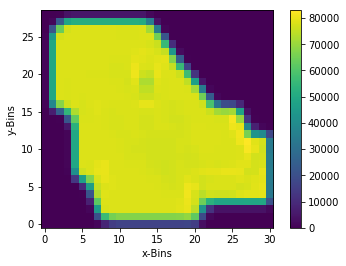

In [13]:
index_bin.show_heatmap()

## Filtration

One can filter indexed traces by some criteria. For example, we can keep only traces with offsets less than 100 as follows:

In [14]:
filtered_index = index_trace.filter('offset', lambda x: x < 100)
filtered_index.head()

offset TraceNumber FieldRecord ShotPoint TRACE_SEQUENCE_FILE  \
                                                              raw   
0        35        1656      111906     42000                   1   
1        36        1657      111906     42000                   2   
2        78        1655      111906     42000                   3   
3        79        1658      111906     42000                   4   
3456     35        1801      111907     42001                3457   

                                              file_id  
                                                  raw  
0     /data/NA/noise_dataset_1/DN02A_LIFT_AMPSCAL.sgy  
1     /data/NA/noise_dataset_1/DN02A_LIFT_AMPSCAL.sgy  
2     /data/NA/noise_dataset_1/DN02A_LIFT_AMPSCAL.sgy  
3     /data/NA/noise_dataset_1/DN02A_LIFT_AMPSCAL.sgy  
3456  /data/NA/noise_dataset_1/DN02A_LIFT_AMPSCAL.sgy

More complex criteria are also supported. Below we keep in index only traces with offset below 100 and TraceNumber not less that 42002:

In [15]:
filtered_index = index_trace.filter(['offset', 'ShotPoint'],
                                    lambda x: (x[0] < 100) & (x[1] >= 42002))
filtered_index.head()

offset TraceNumber FieldRecord ShotPoint TRACE_SEQUENCE_FILE  \
                                                               raw   
6912      35        1800      111908     42002                6913   
6913      35        1801      111908     42002                6914   
6914      79        1799      111908     42002                6915   
6915      79        1802      111908     42002                6916   
10368     35        1800      111909     42003               10369   

                                               file_id  
                                                   raw  
6912   /data/NA/noise_dataset_1/DN02A_LIFT_AMPSCAL.sgy  
6913   /data/NA/noise_dataset_1/DN02A_LIFT_AMPSCAL.sgy  
6914   /data/NA/noise_dataset_1/DN02A_LIFT_AMPSCAL.sgy  
6915   /data/NA/noise_dataset_1/DN02A_LIFT_AMPSCAL.sgy  
10368  /data/NA/noise_dataset_1/DN02A_LIFT_AMPSCAL.sgy

## Conversion between types

Index can be easily converted to other index type. For example, ```FieldIndex``` to ```TraceIndex```:

In [16]:
TraceIndex(index_ffid).head()

FieldRecord TraceNumber TRACE_SEQUENCE_FILE  \
                                          raw   
0         354           1                   3   
1         354           2                   4   
2         354           3                   5   
3         354           4                   6   
4         354           5                   7   

                                             file_id  
                                                 raw  
0  /data/NA/2D_Val/prof_37/segy/00000354_f1.r354.sgy  
1  /data/NA/2D_Val/prof_37/segy/00000354_f1.r354.sgy  
2  /data/NA/2D_Val/prof_37/segy/00000354_f1.r354.sgy  
3  /data/NA/2D_Val/prof_37/segy/00000354_f1.r354.sgy  
4  /data/NA/2D_Val/prof_37/segy/00000354_f1.r354.sgy

or vise-versa:

In [17]:
FieldIndex(index_trace).head()

offset TraceNumber ShotPoint TRACE_SEQUENCE_FILE  \
                                                         raw   
FieldRecord                                                    
111906          35        1656     42000                   1   
111906          36        1657     42000                   2   
111906          78        1655     42000                   3   
111906          79        1658     42000                   4   
111906         127        1654     42000                   5   

                                                     file_id  
                                                         raw  
FieldRecord                                                   
111906       /data/NA/noise_dataset_1/DN02A_LIFT_AMPSCAL.sgy  
111906       /data/NA/noise_dataset_1/DN02A_LIFT_AMPSCAL.sgy  
111906       /data/NA/noise_dataset_1/DN02A_LIFT_AMPSCAL.sgy  
111906       /data/NA/noise_dataset_1/DN02A_LIFT_AMPSCAL.sgy  
111906       /data/NA/noise_dataset_1/DN02A_LIFT_AMPSCAL.sgy

or ```BinsIndex``` to ```FieldIndex```:

In [18]:
FieldIndex(index_bin).head()

bin_id  sline   sid  rline   rid TraceNumber   SourceX    SourceY  \
                                                                                
FieldRecord                                                                     
10001Z       17/20  S2417  5284  R5289  2362         746  509583.9  6615273.0   
10001Z       17/22  S2417  5284  R5277  2427         587  509583.9  6615273.0   
10001Z       18/21  S2417  5284  R5247  2410          50  509583.9  6615273.0   
10001Z       17/22  S2417  5284  R5289  2424         808  509583.9  6615273.0   
10001Z       17/23  S2417  5284  R5277  2455         615  509583.9  6615273.0   

              z_s       x_r        y_r   z_r      CDP_X       CDP_Y   azimuth  \
                                                                                
FieldRecord                                                                     
10001Z       38.1  506859.4  6615497.5  39.9  508221.65  6615385.25  3.059378   
10001Z       38.1  510108.2  6614898.0  36.9  509846.05  6615085.50 -0.620881   
10001Z       38.1  509258.8  6613398.5  35.4  509421.35  6614335.75 -1.742521   
10001Z       38.1  509958.3  6615497.5  37.3  509771.10  6615385.25  0.540145   
10001Z       38.1  511507.9  6614898.0  34.8  510545.90  6615085.50 -0.192493   

                  offset  
                          
FieldRecord               
10001Z       1366.866901  
10001Z        322.302455  
10001Z        951.241328  
10001Z        218.274832  
10001Z        980.102163

or custom shot index to ```FieldIndex```:

In [19]:
FieldIndex(index_shot).head()

ShotPoint TraceNumber TRACE_SEQUENCE_FILE  \
                                                  raw   
FieldRecord                                             
111906          42000        1656                   1   
111906          42000        1657                   2   
111906          42000        1655                   3   
111906          42000        1658                   4   
111906          42000        1654                   5   

                                                     file_id  
                                                         raw  
FieldRecord                                                   
111906       /data/NA/noise_dataset_1/DN02A_LIFT_AMPSCAL.sgy  
111906       /data/NA/noise_dataset_1/DN02A_LIFT_AMPSCAL.sgy  
111906       /data/NA/noise_dataset_1/DN02A_LIFT_AMPSCAL.sgy  
111906       /data/NA/noise_dataset_1/DN02A_LIFT_AMPSCAL.sgy  
111906       /data/NA/noise_dataset_1/DN02A_LIFT_AMPSCAL.sgy

or ```KNNIndex``` to ```FieldIndex```:

In [20]:
FieldIndex(index_knn).head(9)

KNN TraceNumber   CDP_X    CDP_Y TRACE_SEQUENCE_FILE  \
                                                             raw   
FieldRecord                                                        
111906        0        1656  499279  6639805                   1   
111906        0        1657  499304  6639805                   2   
111906        0        1655  499254  6639805                   3   
111906        1        1657  499304  6639805                   2   
111906        1        1656  499279  6639805                   1   
111906        1        1658  499329  6639805                   4   
111906        2        1655  499254  6639805                   3   
111906        2        1656  499279  6639805                   1   
111906        2        1654  499229  6639805                   5   

                                                     file_id  
                                                         raw  
FieldRecord                                                   
111906       /data/NA/noise_dataset_1/DN02A_LIFT_AMPSCAL.sgy  
111906       /data/NA/noise_dataset_1/DN02A_LIFT_AMPSCAL.sgy  
111906       /data/NA/noise_dataset_1/DN02A_LIFT_AMPSCAL.sgy  
111906       /data/NA/noise_dataset_1/DN02A_LIFT_AMPSCAL.sgy  
111906       /data/NA/noise_dataset_1/DN02A_LIFT_AMPSCAL.sgy  
111906       /data/NA/noise_dataset_1/DN02A_LIFT_AMPSCAL.sgy  
111906       /data/NA/noise_dataset_1/DN02A_LIFT_AMPSCAL.sgy  
111906       /data/NA/noise_dataset_1/DN02A_LIFT_AMPSCAL.sgy  
111906       /data/NA/noise_dataset_1/DN02A_LIFT_AMPSCAL.sgy

Note that the index obtained contains 3 times duplicated traces. To remove them use ```drop_duplicates```:

In [21]:
FieldIndex(index_knn).drop_duplicates().head(9)

KNN TraceNumber   CDP_X    CDP_Y TRACE_SEQUENCE_FILE  \
                                                             raw   
FieldRecord                                                        
111906        0        1656  499279  6639805                   1   
111906        0        1657  499304  6639805                   2   
111906        0        1655  499254  6639805                   3   
111906        1        1658  499329  6639805                   4   
111906        2        1654  499229  6639805                   5   
111906        3        1659  499354  6639805                   6   
111906        4        1653  499204  6639805                   7   
111906        5        1660  499379  6639805                   8   
111906        6        1652  499179  6639805                   9   

                                                     file_id  
                                                         raw  
FieldRecord                                                   
111906       /data/NA/noise_dataset_1/DN02A_LIFT_AMPSCAL.sgy  
111906       /data/NA/noise_dataset_1/DN02A_LIFT_AMPSCAL.sgy  
111906       /data/NA/noise_dataset_1/DN02A_LIFT_AMPSCAL.sgy  
111906       /data/NA/noise_dataset_1/DN02A_LIFT_AMPSCAL.sgy  
111906       /data/NA/noise_dataset_1/DN02A_LIFT_AMPSCAL.sgy  
111906       /data/NA/noise_dataset_1/DN02A_LIFT_AMPSCAL.sgy  
111906       /data/NA/noise_dataset_1/DN02A_LIFT_AMPSCAL.sgy  
111906       /data/NA/noise_dataset_1/DN02A_LIFT_AMPSCAL.sgy  
111906       /data/NA/noise_dataset_1/DN02A_LIFT_AMPSCAL.sgy

## Merge

Two index instances can be merged on common headers. For example, ```index_ffid``` does not contain offsets. However, we can merge it with ```index_sps``` that includes offsets:

In [22]:
index_ffid = index_ffid.merge(index_sps)
index_ffid.head()

TraceNumber TRACE_SEQUENCE_FILE  \
                                        raw   
FieldRecord                                   
354                   1                   3   
354                   2                   4   
354                   3                   5   
354                   4                   6   
354                   5                   7   

                                                       file_id sline   sid  \
                                                           raw               
FieldRecord                                                                  
354          /data/NA/2D_Val/prof_37/segy/00000354_f1.r354.sgy   S37  3591   
354          /data/NA/2D_Val/prof_37/segy/00000354_f1.r354.sgy   S37  3591   
354          /data/NA/2D_Val/prof_37/segy/00000354_f1.r354.sgy   S37  3591   
354          /data/NA/2D_Val/prof_37/segy/00000354_f1.r354.sgy   S37  3591   
354          /data/NA/2D_Val/prof_37/segy/00000354_f1.r354.sgy   S37  3591   

            rline  rid point_index sht_depth uphole    SourceX    SourceY  \
                                                                            
FieldRecord                                                                 
354           R37  219           1      18.0   14.0  338886.78  7033413.0   
354           R37  220           1      18.0   14.0  338886.78  7033413.0   
354           R37  221           1      18.0   14.0  338886.78  7033413.0   
354           R37  222           1      18.0   14.0  338886.78  7033413.0   
354           R37  223           1      18.0   14.0  338886.78  7033413.0   

              z_s        x_r        y_r   z_r      CDP_X       CDP_Y  \
                                                                       
FieldRecord                                                            
354          71.5  338560.00  7029929.5  76.0  338723.39  7031671.25   
354          71.5  338562.40  7029954.5  76.1  338724.59  7031683.75   
354          71.5  338564.70  7029979.5  76.2  338725.74  7031696.25   
354          71.5  338567.00  7030004.5  76.8  338726.89  7031708.75   
354          71.5  338569.38  7030029.0  77.4  338728.08  7031721.00   

              azimuth       offset  
                                    
FieldRecord                         
354         -1.664331  1749.396855  
354         -1.664315  1736.839416  
354         -1.664328  1724.286648  
354         -1.664341  1711.733880  
354         -1.664317  1699.426283

Enjoy!